# Static potential with fermions

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit

from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../") # go to parent dir
from itertools import permutations,product
from tqdm.notebook import tqdm
import datetime
import scipy.sparse as sp
from time import perf_counter

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib as mpl

from Hamiltonian_QED_sym import HamiltonianQED_sym
from Hamiltonian_QED_oprt import HamiltonianQED_oprt
from HC_Lattice import HCLattice
from Ansaetze import Ansatz
import primme

#local import
from Observables import *
from Fidelity_func import *

#Qiskit import
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_distribution
from qiskit.circuit import Parameter
import qiskit.quantum_info as qinf
from qiskit.primitives import Sampler, Estimator
#from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit.quantum_info import SparsePauliOp, Pauli, Operator
from sys import stdout
from qiskit_algorithms.optimizers import NFT,SLSQP,COBYLA,ADAM,SPSA,QNSPSA,CG,GradientDescent,L_BFGS_B
from qiskit.quantum_info.states import DensityMatrix
import qiskit.quantum_info as qinf
from qiskit.quantum_info import entropy
from qiskit_algorithms.eigensolvers import VQD
from qiskit_algorithms.minimum_eigensolvers import VQE


/var/folders/08/fx8gnyrx18jggry6_s4cbtz40000gn/T/ipykernel_12107/1953758291.py:23: DeprecationWarning: Please use `aslinearoperator` from the `scipy.sparse.linalg` namespace, the `scipy.sparse.linalg.interface` namespace is deprecated.
  import primme


In [3]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes,inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import re
import matplotlib as mpl
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "14"
mpl.rcParams["font.serif"] = "STIX"
mpl.rcParams["mathtext.fontset"] = "stix"

# Set the font family to a serif font available on your system (e.g., 'Times New Roman')
plt.rcParams['font.serif'] = ['Times New Roman']

# Disable TeX rendering
plt.rcParams['text.usetex'] = False

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

##### Hamiltonian

[{(0, 0): -1, (0, 1): 1} {(0, 0): -1, (1, 0): 1} {(0, 0): -1, (2, 1): 1}] {1.0, 2.23606797749979}


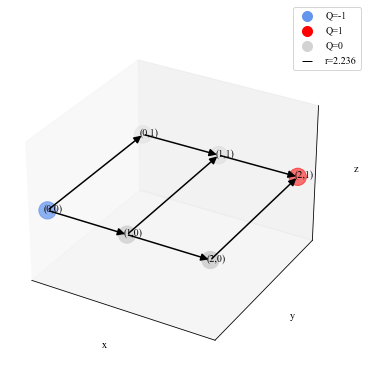

In [4]:
#class input parameters:
n_sites = [3,2]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=2
omega=1
l=1
L=8
rotors = False
lambd = 1000
encoding = 'gray' ##'ed'#
magnetic_basis=False
pbc=False
puregauge = False
static_charges_values =None#{(0,0):1,(1,0):-1}#TODO: no conditions applied, like charge conservation, etc. For conditions see func_qstatic_dist
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign
sparse_pauli =False #false for circuit ansatz
#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 1

#lattice
latt = HCLattice(n_sites,pbc=pbc,puregauge=puregauge)

#static charge
latt.func_qstatic_dist()#charge=(1,0))
static_charges_values_input = latt.distances_coord
print(static_charges_values_input,set(latt.r_list))
qstat=static_charges_values_input[-1]

#qstat={(0,0):-1,(2,1):1}
#latt.func_qstatic_dist((2,1),ch_val=2)


#[latt.draw_graph_func(gauss_law_fig=False,static_charges=st) for st in static_charges_values_input]

latt.draw_graph_func(gauss_law_fig=False,static_charges=qstat)#,savefig_dir='.')

In [5]:
from sympy import Symbol
e_op_free_input=['q_10', 'q_20', 'q_21', 'q_11', 'q_01','E_10y', 'E_20y',]#if fermions then also put charges!
e_op_free_input=[Symbol(e) for e in e_op_free_input]

# Creating a configuration dictionary with common inputs
config = {
    'latt': latt,
    'n_sites': n_sites,
    'l':l,
    'L':L,
    'encoding':encoding,
    'magnetic_basis': magnetic_basis,
    'pbc': pbc,
    'puregauge': puregauge,
    'static_charges_values': qstat,
    'e_op_out_plus': e_op_out_plus,
    'e_op_free_input':e_op_free_input
}
hamilt_sym = HamiltonianQED_sym(config,display_hamiltonian=False)
class_H_oprt = HamiltonianQED_oprt( config,hamilt_sym, sparse_pauli=sparse_pauli)


ngauge = class_H_oprt.len_e_op
# if puregauge:
#     n_qubits_f = 0
# else:
#     n_qubits_f = np.prod(latt.n_sites)

# n_qubits =int(np.ceil(np.log2(2 * l+ 1)))

HamiltonianQED_sym: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.04296398162841797 seconds
HamiltonianQED_oprt: Initializing...
> e_op_free and u_op_free built
> Pauli strings built
Hamiltonian_el_pauli done
>> Hamiltonian built.  Execution time: 4.222714185714722 seconds
>> Suppression term built.  Execution time: 0.015449047088623047 seconds


In [6]:
class_H_oprt.qop_list[::-1]+class_H_oprt.uop_list[::-1]#order of operators in tensor product and on circuit little endian ..q2q1q0

[q_01, q_11, q_21, q_20, q_10, q_00, U_20y, U_10y]

In [7]:

#print('or charges')
for i,k in enumerate(class_H_oprt.uop_list+class_H_oprt.qop_list):
    print(f'qubit{i}:{k}')

qubit0:U_10y
qubit1:U_20y
qubit2:q_00
qubit3:q_10
qubit4:q_20
qubit5:q_21
qubit6:q_11
qubit7:q_01


##### Quantum circuit: with fermions

Total n.er of qubits: 10
Total n.er of CNOT gates (Toffoli are decomposed): 140
Total n.er of parameters: 20
CNOT depth: 68


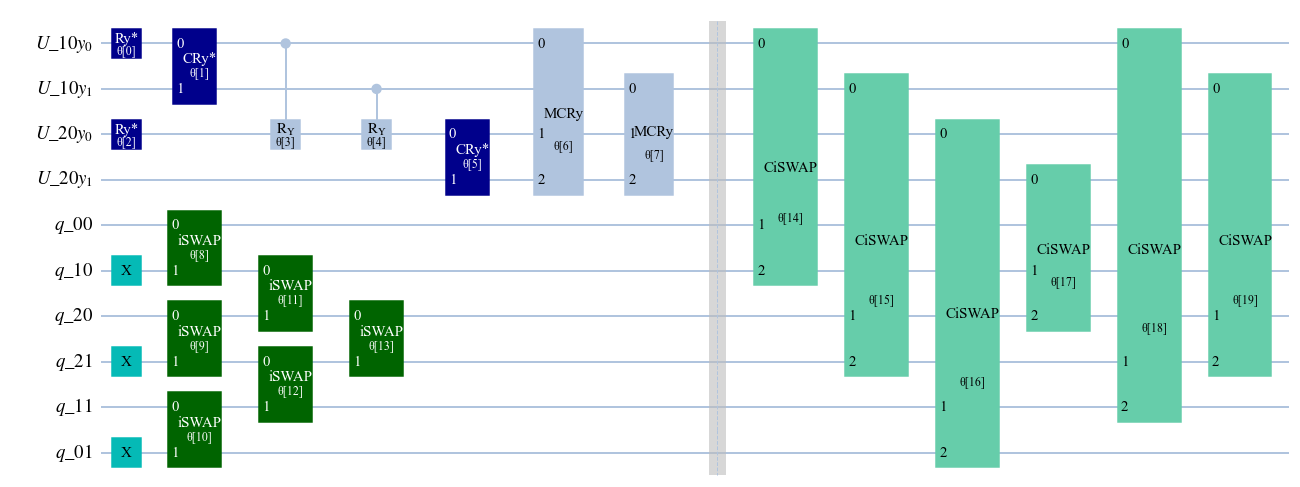

In [79]:
nlayers= 1
entanglement='full'#triangular,linear,full
rzlayer=False
ngauge = class_H_oprt.len_e_op
if puregauge:
    n_qubits_f = 0
else:
    n_qubits_f = np.prod(latt.n_sites)

n_qubits =int(np.ceil(np.log2(2 * l+ 1)))


ansatz_class = Ansatz(l,ngauge,nfermions=n_qubits_f,gauge_list= class_H_oprt.uop_list,ferm_list=class_H_oprt.qop_list)
qc_tot2,first_layer_par = ansatz_class.gauge_fermion_circuit(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)
print('Total n.er of qubits:',qc_tot2.num_qubits)
print('Total n.er of CNOT gates (Toffoli are decomposed):',dict(qc_tot2.decompose(reps=6).count_ops())['cx'])
print('Total n.er of parameters:',qc_tot2.num_parameters)
depth = qc_tot2.decompose(reps=4).depth(lambda x: x[0].num_qubits == 2)
print("CNOT depth:",depth)
#print(ansatz_class.first_layer_par)
#parameter counts
#ansatz_class.parameters_count(n_qubits,ngauge)
qc_tot2.draw('mpl',fold=50,
             style=ansatz_class.style)
# qc_tot2.decompose(reps=6).draw('mpl',fold=50,
#              style=ansatz_class.style)

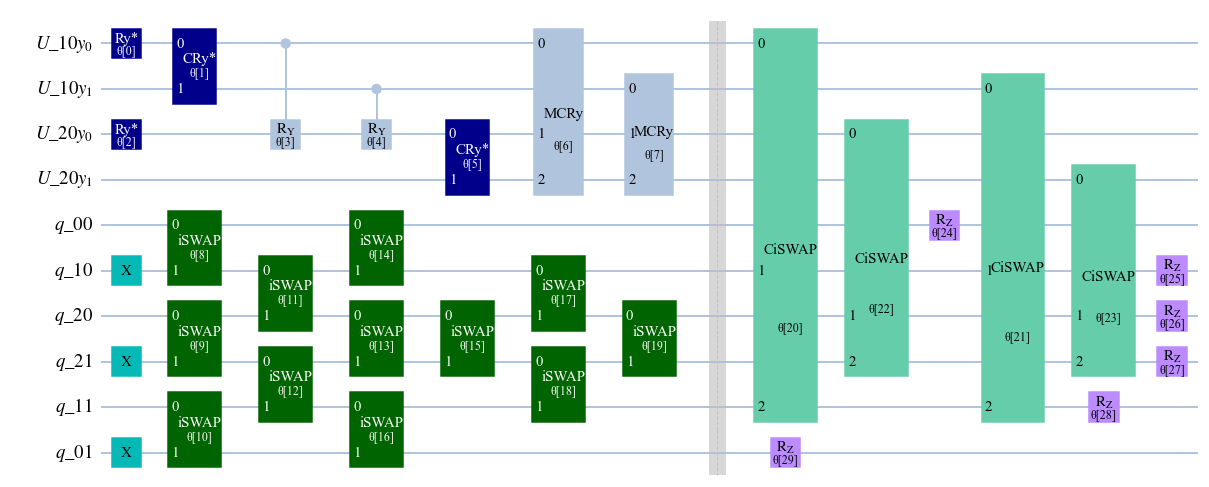

In [92]:
#NEW CIRCUIT
params = lambda i: Parameter(f"θ[{i}]")

qc_gauge,first_layer_par,th_gauge= ansatz_class.puregauge_circuit_entang(entanglement=entanglement,rzlayer=rzlayer,nlayers=nlayers)

qreg_g=[]
qreg_f=[]
if ansatz_class.gauge_list:
    for i in [str(k) for k in ansatz_class.gauge_list]:
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits,name=i))
else:
    for i in range(ansatz_class.ngauge):
        qreg_g.append(QuantumRegister(ansatz_class.n_qubits,name=f'g{i}'))
if ansatz_class.ferm_list:
    for f in [str(i) for i in ansatz_class.ferm_list]:
        qreg_f.append(QuantumRegister(1,name=f))
else:
    for i in range(ansatz_class.nfermions):
        qreg_f.append(QuantumRegister(1,name=f'f{i}'))

qc_tot2 = QuantumCircuit(*qreg_g,*qreg_f)

#gauge part
qc_tot2.compose(qc_gauge,range(ansatz_class.ngauge*ansatz_class.n_qubits),inplace=True)

#fermionic part
qc_ferm,th = ansatz_class.fermionic_circuit(th_ferm=th_gauge,nlayers=2)
qc_tot2.compose(qc_ferm,range(ansatz_class.ngauge*ansatz_class.n_qubits,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions),inplace=True)

qc_tot2.barrier()

# ctrlgauge=[np.arange(ansatz_class.ngauge*ansatz_class.n_qubits)[i % (ansatz_class.ngauge*ansatz_class.n_qubits)] for i in range(ansatz_class.nfermions)]
# count=0
# for j in range(ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions//2):
#     for i in range(ansatz_class.ngauge*ansatz_class.n_qubits+j,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions-j,2):

#         #print([ctrlgauge[count],i,i+1])
#         #Ansatz.CiSwap(qc_tot2,k,range(i,i+2),params(th))
#         qc_tot2.append(Ansatz.CiSwap2(params(th)),[ctrlgauge[count],i,i+1])
#         th+=1
#         count+=1
# for j in range(ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions//2):
#     for i in range(ansatz_class.ngauge*ansatz_class.n_qubits+j,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions-j,2):
#         qc_tot2.append(Ansatz.CiSwap2(params(th)),[k,i,i+1])
for pair in [[0,5,8],[1,5,8],[2,6,7],[3,6,7]]:
    qc_tot2.append(Ansatz.CiSwap2(params(th)),pair)
    th+=1

#rz layer for fermions
for i in range(ansatz_class.ngauge*ansatz_class.n_qubits,ansatz_class.ngauge*ansatz_class.n_qubits+ansatz_class.nfermions):
    qc_tot2.rz(params(th),i)
    th+=1


qc_tot2.draw('mpl',fold=50,
             style=ansatz_class.style)

In [93]:
print("Total numer of gates",qc_tot2.decompose(reps=6).count_ops())

Total numer of gates OrderedDict([('u', 247), ('cx', 152), ('barrier', 1)])


#### Read datafile

In [160]:
nshots=10000

In [167]:
#read data from file
# with open('static_potential_3x2_m2_omega1_l1_mutualinfoansatz.txt','r'):
def read_datafile_glist(filetxt,nshots=None):
    filename = filetxt  # Replace this with the actual path to your file

    # Define regular expressions to extract the required data
    pattern_g=r'g=(-?\d+\.\d+)'
    pattern_ed = r'ed0=(-?\d+\.\d+)'
    pattern_ed_dict=r'ed_dict=\{([\s\S]+?)\}'

    pattern_vqd = r'vqe0=(-?\d+\.\d+)'
    pattern_vqd_dict =r'vqe_dict=\{([\s\S]+?)\}'
    if nshots:
        pattern_std_dev = r'std_dev=(-?\d+\.\d+)'
    pattern_fidelity = r'fidelity=(\d+\.\d+)'
    pattern_parameters = r'optimal_point=\[([\s\d\.\-\+eE]+)\]'

    g_values=[]
    ed_values = []
    dict_ed=[]
    vqe_values = []
    dict_vqe=[]
    std_dev_values = []
    fidelity_values = []
    parameters_values = []

    with open(filename, 'r') as file:
        data = file.read()

        g_values = np.array(list(map(float, re.findall(pattern_g, data))))
        # Extract E_0(ED) values
        ed_values = np.array(list(map(float, re.findall(pattern_ed, data))))

        # Extract E_0(VQD) values
        vqe_values = np.array(list(map(float, re.findall(pattern_vqd, data))))

        for k,g in enumerate(g_values):
            # Extract dict_ed string
            #list_ed_tmp=[eval(el[:-1]) for el in re.findall(pattern_ed_dict, data)[k].split()]
            list_ed_tmp=[el for el in re.findall(pattern_ed_dict, data)[k].split()]
            #dict index even keys , index odd values
            dict_ed_tmp = {eval(list_ed_tmp[i][:-1]):eval(list_ed_tmp[i+1]) for i in range(0,len(list_ed_tmp),2)}
            dict_ed_tmp = {key: float(v[0]) if isinstance(v, tuple) else float(v) for key, v in dict_ed_tmp.items()}


            dict_ed.append(dict_ed_tmp)

            # Extract dict_vqe string
            list_vqd_tmp=[el for el in re.findall(pattern_vqd_dict, data)[k].split()]
            #dict index even keys , index odd values
            dict_vqe_tmp = {eval(list_vqd_tmp[i][:-1]):eval(list_vqd_tmp[i+1]) for i in range(0,len(list_vqd_tmp),2)}
            dict_vqe_tmp = {key: float(v[0]) if isinstance(v, tuple) else float(v) for key, v in dict_vqe_tmp.items()}

            dict_vqe.append(dict_vqe_tmp)

        # Extract std. dev. values
        std_dev_values = np.array(list(map(float, re.findall(pattern_std_dev, data))))

        # Extract Fidelity (|psi_VQDXpsi_ED|^2) values
        fidelity_values = np.array(list(map(float, re.findall(pattern_fidelity, data))))

        # Extract Parameters values
        parameters_matches = re.finditer(pattern_parameters, data)
        #print(parameters_matches)

        parameters_list = [np.array(list(map(float, match.group(1).split()))) for match in parameters_matches]
        #print(parameters_list)
    return g_values,ed_values,dict_ed, vqe_values, std_dev_values,dict_vqe, fidelity_values, parameters_list

better fidelity 1st case only string breaking: 0.9626797925361238 0.9540078512269803
better fidelity 2nd case: 0.970285011196226 0.9705695844159528
better fidelity 2nd case: 0.9717420997300409 0.9733234166990358
better fidelity 1st case only string breaking: 0.9729839274985679 0.9727542144592782
better fidelity 2nd case: 0.9687899303679264 0.9690398049857457
better fidelity 1st case only string breaking: 0.9645724985982246 0.9635060909300862
better fidelity 2nd case: 0.95116279147767 0.9553958487951125
better fidelity 2nd case: 0.9245502594394686 0.9476679125022209
better fidelity 2nd case: 0.9007604270852255 0.9481534995196637
better fidelity 1st case only string breaking: 0.9982669512901162 0.0002444533843875722
better fidelity 1st case only string breaking: 0.9989411379560382 0.00012402340170430438
better fidelity 1st case only string breaking: 0.9993408516233399 0.00010775981457796836
better fidelity 1st case only string breaking: 0.9995957242192024 0.00020549875867791056
better fi

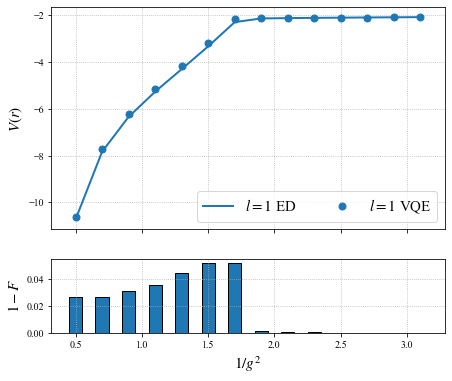

In [168]:
g_values_file,ed_values_file,dict_ed_file, vqe_values_file, std_dev_values_file,dict_vqe_file, fidelity_values_file, parameters_list_file=read_datafile_glist('static_potential_3x2_m2_omega1_l1_mutualinfoansatz.txt',nshots=nshots)
g_values_file_v2,ed_values_file_v2,dict_ed_file_v2, vqe_values_file_v2, std_dev_values_file_v2,dict_vqe_file_v2, fidelity_values_file_v2, parameters_list_file_v2=read_datafile_glist('static_potential_3x2_m2_omega1_l1_mutualinfoansatz_v2.txt',nshots=nshots)


for fid,fid_2,i in zip(fidelity_values_file,fidelity_values_file_v2,range(len(g_values_file))):
    if fid>=fid_2:
        print('better fidelity 1st case only string breaking:',fid,fid_2)
    else:
        print('better fidelity 2nd case:',fid,fid_2)
        g_values_file[i]=g_values_file_v2[i]
        ed_values_file[i]=ed_values_file_v2[i]
        dict_ed_file[i]=dict_ed_file_v2[i]
        vqe_values_file[i]=vqe_values_file_v2[i]
        dict_vqe_file[i]=dict_vqe_file_v2[i]
        std_dev_values_file[i]=std_dev_values_file_v2[i]
        fidelity_values_file[i]=fidelity_values_file_v2[i]
        parameters_list_file[i]=parameters_list_file_v2[i]


fig,ax =plt.subplots(2,figsize=(set_size(width)[0],6),sharex=True,gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(g_values_file[2:],ed_values_file[2:],markersize=6,markeredgewidth=2,label=f'$l=1$ ED',linewidth=2)
ax[0].plot(g_values_file[2:],vqe_values_file[2:],'o',markersize=7,color='C0',label='$l=1$ VQE')
ax[0].set_ylabel(r'$V(r)$',fontsize=15)
ax[0].legend(fontsize=15,ncols=3,loc='lower right')

#ax[1].bar(g_list,np.abs(np.array(vqe_results)-np.array(ed_results)/np.array(ed_results)), edgecolor='black',width=0.1)
ax[1].bar(g_values_file[2:],1-fidelity_values_file[2:], edgecolor='black',width=0.1)

ax[1].set_ylabel(r'$1-F$',fontsize=15)
ax[1].set_xlabel(r'$1/g^2$',fontsize=15)


for i in [0,1]:
    ax[i].grid(True,which='both',linestyle='dotted')


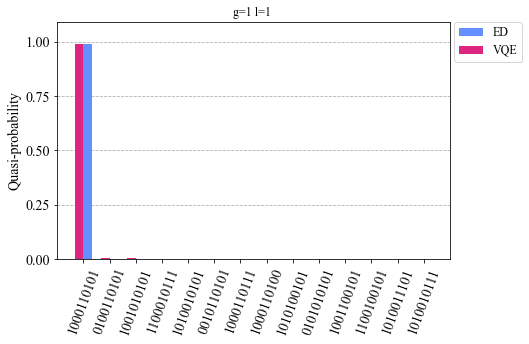

In [171]:
from qiskit.visualization import plot_distribution
width=510
#TODO: test the other configurations here only -1 last one
fig_hist=plot_distribution([dict_ed_file[-1] ,dict_vqe_file[-1] ], figsize=set_size(width),legend=['ED','VQE'] ,bar_labels=False,number_to_keep=10,sort='value_desc',
               title=f'g={g} l={l} ')
               #,filename=f'plots/E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png')
fig_hist
#fig_hist.savefig(f'plots/E_0_ED_vs_VQD_test:{latt.dims}D_'+'x'.join(map(str,latt.n_sites))+f'mbasis{magnetic_basis}_puregauge{puregauge}_g{g}_pbc{pbc}_l{l}_nlayers{nlayers}_iterations{iterations}.png',dpi=600, bbox_inches="tight")


('1000110101', 0.9899240582790358)


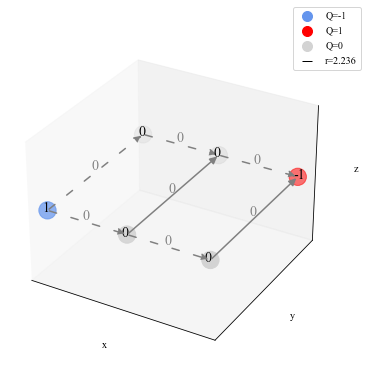

In [172]:
for key,val in {key:val for key,val in dict_vqe_file[-1].items() if val>1e-1}.items():
    conf = class_H_oprt.eop_config_from_string(key)
    print((key,val))
    latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H_oprt.e_op_free,static_charges=qstat,weight=conf)#,savefig_dir='Images/',figname=f'config_g{g}_l{l}_E_0_VQD_{key}_probab{np.round(val,2)}.png')